# CCLE Simple autoencoder 

Making the model to use later in trianing: 

In [1]:
from time import time
import re, sys, os
from keras import metrics
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import History, EarlyStopping 
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib. pyplot as plt 

user = '/rumi/shams/abe/'

Using TensorFlow backend.


In [19]:
def read_data(user=user, dtype = 'counts'):
    t0 = time()
    data_folder = user + 'Datasets/CCLE/'
    m_rna_counts = data_folder + 'CCLE_RNAseq_genes_counts_20180929.gct.gz'
    m_rna_rpkm = data_folder + 'CCLE_RNAseq_genes_rpkm_20180929.gct.gz'
    
    # select input format 
    if dtype == 'counts':
        m_rna = m_rna_counts
    elif dtype == 'rpkm':
        m_rna = m_rna_rpkm
    
    # read raw data
    raw_m_rna = pd.read_csv(m_rna, skiprows=2, sep='\t')

    # make meta data dictionary 
    meta = {'m_rna': raw_m_rna[['Name','Description']],
            'cell_lines': raw_m_rna.columns.values.tolist()[2:]}
    # normalize
    df_m_rna = raw_m_rna.drop(columns=['Name','Description']).to_numpy()
    df_m_rna = normalize(X=df_m_rna, axis=0, norm="max")
    data = {'df':df_m_rna, 'meta': meta}
    return data 


def simple_autoencoder(df, test_size=0.10, batch_size=64, epochs =5, 
                       user=user, save=False, plot=True,
                       dim_en=32, n_en=2, n_de=2):
    def create_model(input_size):
        # this is our input placeholder
        myinput = Input(shape=(input_size,))
        ### first layer:
        encoded = Dense(dim_en*2**n_en, activation='relu')(myinput)
        ### hidden layers
        # encoding 
        for n in range(n_en-1,-1,-1):
            encoded = Dense(dim_en*2**n, activation='relu')(encoded)
        # final "encoded" is the encoded representation of the input
        # decoding 
        for n in range(n_de):
            decoded = Dense(dim_en*2**n, activation='relu')(encoded)
        decoded = Dense(dim_en*2**n_de, activation='relu')(decoded)
        ### last layer:
        decoded = Dense(input_size, activation='linear')(decoded)
        ### make autoencoder model 
        autoencoder = Model(myinput, decoded)
        # Separate encoder model: this model maps an input to its encoded representation
        encoder = Model(myinput, encoded)
        autoencoder.compile(
            optimizer='adadelta', 
            loss='mse',
            metrics=['accuracy']
        )
        return autoencoder #, encoder
    
    # make X and y from df
    X = df.T
    y = X
    X_train, X_test,_,_ = train_test_split(X, X, test_size=test_size, random_state=42)
    # callbacks 
    history = History()
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5) 
    
    print (f'Input shape: {X.shape[0]} Cell lines X {X.shape[1]} RNAseq genes')
    print (f'Batch size {batch_size}, epochs {epochs}')
    print (f'encoded in {dim_en} dimentions, {n_en} encoding layers & {n_de} decoding layers')
    
    # make and fit the model
    model = create_model(input_size=X.shape[1])
    model.fit(X_train, X_train,
              epochs=epochs,
              batch_size=batch_size,
              shuffle=True,
              callbacks=[history,early_stopping],
              validation_data=(X_test, X_test)
             )
    print("fitting has just been finished")
    _, train_acc = model.evaluate(X_train, X_train, verbose=0)
    _, test_acc = model.evaluate(X_test, X_test, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    X_pred = model.predict(X_test, batch_size=batch_size, verbose=2)    
    print("prediction process has just been finished")   
    if save:
        results_folder = user + 'Projects/GI_predictor/Results/'
        model_path = results_folder+"epochs-"+str(epochs)+'_encoded-'+str(dim_en)+'.'+str(n_en)+'.'+str(n_de)+'/'
        
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        # save the model and encoded-layer output
        model.save(filepath=model_path+"model.h5")
        # save the result and prediction value
        np.savetxt(X=X_test, fname=model_path+"X_test.csv", delimiter=",")
        np.savetxt(X=X_pred[0], fname=model_path+"X_pred.csv", delimiter=",")
    if plot:
        if early_stopping.stopped_epoch == 0:
            epochs = range(epochs)
            loss = model.history.history['loss']
            val_loss = model.history.history['val_loss']
            plt.figure()
            plt.plot(epochs, loss, 'bo', label='Training loss')
            plt.plot(epochs, val_loss, 'b', label='Validation loss')
            plt.title('Training and validation loss')
            plt.legend()
            if save:
                plt.savefig(model_path+'loss.pdf')
            plt.show()

            acc = model.history.history['accuracy']
            val_acc = model.history.history['val_accuracy']
            plt.figure() 
            plt.plot(epochs, acc, 'bo', label='Training Acc')
            plt.plot(epochs, val_acc, 'b', label='Validation Acc')
            plt.title('Model accuracy')
            plt.ylabel('Accuracy') 
            plt.xlabel('Epoch')
            plt.legend(['Trian', 'Test'])
            if save:
                plt.savefig(model_path+'acc.pdf')
            plt.show()

In [3]:
data = read_data()
cell_lines = data['meta']['cell_lines']
df = data['df']

Input shape: 1019 Cell lines X 56202 RNAseq genes
Train on 917 samples, validate on 102 samples
Epoch 1/5
917/917 [==============================] - 4s 4ms/step - loss: 9.4116e-05 - accuracy: 0.0611 - val_loss: 9.3948e-05 - val_accuracy: 0.4020
Epoch 2/5
917/917 [==============================] - 3s 3ms/step - loss: 9.4048e-05 - accuracy: 0.5202 - val_loss: 9.3881e-05 - val_accuracy: 0.5000
Epoch 3/5
917/917 [==============================] - 3s 3ms/step - loss: 9.3979e-05 - accuracy: 0.5540 - val_loss: 9.3814e-05 - val_accuracy: 0.5000
Epoch 4/5
917/917 [==============================] - 3s 3ms/step - loss: 9.3910e-05 - accuracy: 0.5540 - val_loss: 9.3747e-05 - val_accuracy: 0.5000
Epoch 5/5
917/917 [==============================] - 2s 3ms/step - loss: 9.3842e-05 - accuracy: 0.5540 - val_loss: 9.3679e-05 - val_accuracy: 0.5000
fitting has just been finished
prediction process has just been finished


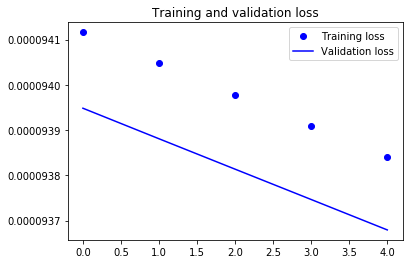

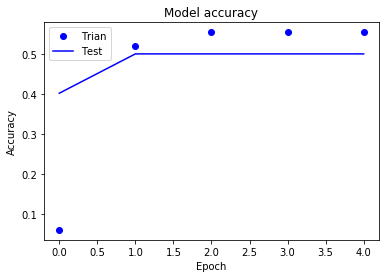

In [4]:
simple_autoencoder(df)

In [18]:
for n in [1,3,5]:
    for d in [16,32,64]:
        for b in [32,256]:
            simple_autoencoder(df, epochs=50, 
                               n_en=n, n_de=n,
                               dim_en=d,
                               batch_size=b
                              )

Input shape: 1019 Cell lines X 56202 RNAseq genes
Batch size 32, epochs 50
encoded in 16 dimentions, 1 encoding layers & 1 decoding layers
Train on 917 samples, validate on 102 samples
Epoch 1/50
917/917 [==============================] - 3s 4ms/step - loss: 9.4063e-05 - accuracy: 0.3904 - val_loss: 9.3866e-05 - val_accuracy: 0.5000
Epoch 2/50
917/917 [==============================] - 3s 3ms/step - loss: 9.3931e-05 - accuracy: 0.5540 - val_loss: 9.3736e-05 - val_accuracy: 0.5000
Epoch 3/50
917/917 [==============================] - 2s 3ms/step - loss: 9.3799e-05 - accuracy: 0.5540 - val_loss: 9.3607e-05 - val_accuracy: 0.5000
Epoch 4/50
917/917 [==============================] - 2s 3ms/step - loss: 9.3667e-05 - accuracy: 0.5540 - val_loss: 9.3479e-05 - val_accuracy: 0.5000
Epoch 5/50
917/917 [==============================] - 2s 3ms/step - loss: 9.3535e-05 - accuracy: 0.5540 - val_loss: 9.3350e-05 - val_accuracy: 0.5000
Epoch 6/50
917/917 [==============================] - 2s 2ms/step

In [38]:
[[i, cell] for i, cell in enumerate(cell_lines) if 'K562' in cell ]

[[385, 'K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE']]

In [43]:
[[i, cell] for i, cell in enumerate(cell_lines) if 'JURKAT' in cell ]

[[380, 'JURKAT_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE']]

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact, spearmanr
import plotly as py
import plotly.tools as tls
from screen import get_SLdataset, get_gene_pairs

## GI Scores
Load data from [Mapping the Genetic Landscape of Human Cells](https://www.sciencedirect.com/science/article/pii/S0092867418307359?via%3Dihub#mmc2) paper. 
> [**Table S5.**](https://www.sciencedirect.com/science/article/pii/S0092867418307359?via%3Dihub#mmc5)

In [33]:
SL_dataset = get_SLdataset()

K562: 99.55%	100128 SLs from 100576 unique gene pairs
Jurkat: 99.49%	75078 SLs from 75466 unique gene pairs 
done in 54.022702s


## Input data: cBioportal cohorts 

## 1st
- ### [Acute Myeloid Leukemia (OHSU, Nature 2018)](https://www.cbioportal.org/study?id=aml_ohsu_2018)

In [ ]:
f_path = 'cBioPortal/aml_ohsu_2018/' + 'data_RNA_Seq_expression_cpm_Zscores.txt'
# ls cBioPortal/aml_ohsu_2018

In [16]:
data = pd.read_csv(f_path,sep='\t', index_col='Hugo_Symbol', 
                   na_values ='NA').drop(columns='Entrez_Gene_Id').astype(float)

gene pairs for **K562** GI pairs:

In [31]:
cell_line = 'K562'
data_G1, data_G2 = get_gene_pairs(SL_dataset[cell_line], data)
X = np.concatenate((    np.array (data_G1.T),    np.array (data_G2.T)))
# this is our input:
print (f'num of patients X 2 = {X.shape[0]} \nnum of gene pairs (Obs.) = {X.shape[1]}')

num of patients X 2 = 902 
num of gene pairs (Obs.) = 657


gene pairs for **Jurkat** GI pairs:

# 2nd
- ### [Pediatric Acute Lymphoid Leukemia - Phase II (TARGET, 2018)](https://www.cbioportal.org/study?id=all_phase2_target_2018_pub)

In [44]:
# ls cBioPortal/all_phase2_target_2018_pub

In [43]:
# meta data
filepath = 'cBioPortal/all_phase2_target_2018_pub/meta_study.txt'
with open(filepath) as fp:
    print( fp.read() )

type_of_cancer: bll
cancer_study_identifier: all_phase2_target_2018_pub
name: Pediatric Acute Lymphoid Leukemia - Phase II (TARGET, 2018)
short_name: ALL-Phase II (TARGET, 2018)
description: Comprehensive profiling of ALL Phase 2 samples. <p>TARGET data is intended exclusively for biomedical research using pediatric data (i.e., the research objectives cannot be accomplished using data from adults) that focus on the development of more effective treatments, diagnostic tests, or prognostic markers for childhood cancers. Moreover, TARGET data can be used for research relevant to the biology, causes, treatment and late complications of treatment of pediatric cancers, but is not intended for the sole purposes of methods and/or tool development (please see <a href="https://ocg.cancer.gov/programs/target/using-target-data">Using TARGET Data</a> section of the OCG website). If you are interested in using TARGET data for publication or other research purposes, you must follow the <a href="https

In [51]:
f_path = 'cBioPortal/all_phase2_target_2018_pub/' + 'data_RNA_Seq_mRNA_median_Zscores.txt'
data = pd.read_csv(f_path,sep='\t', index_col='Hugo_Symbol', 
                   na_values ='NA', na_filter = True).astype(float)

In [ ]:
data.isna

gene pairs for **K562** GI pairs:

gene pairs for **Jurkat** GI pairs: